In [46]:
import zipfile as ZipFile
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from PIL import Image

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
train_image = "/content/drive/MyDrive/Tamil Dataset/Tamil Uriye Eluthukal/train-image-1591211703.9039922.npy"
train_label = "/content/drive/MyDrive/Tamil Dataset/Tamil Uriye Eluthukal/train-label-1591211706.368335-onehot.npy"

In [31]:
train_X = np.load(train_image)
train_y = np.load(train_label)

In [88]:
train_X.shape

(60000, 784)

[0 0 0 0 0 0 0 0 0 0 0 0 1]
12


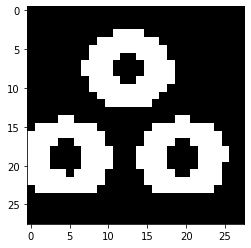

In [257]:
index = 90
plt.imshow(train_X[index].reshape(28,28),cmap="gray")
print(train_y[index])
print(train_y[index].argmax())

In [258]:
class TamilLang(Dataset):

  def __init__(self,X,y,transform=None):
    self.X = X
    self.y = y
    self.transform = transform

  def __len__(self):
    return len(self.X)

  def __getitem__(self,index):
    x = Image.fromarray(self.X[index].reshape(28,28))
    y = self.y[index].argmax()

    if self.transform != None:
      x = self.transform(x)
    
    return x,y


In [259]:
train_transforms =  transforms.Compose([
        # transforms.Resize((28, 28)),
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
])

In [260]:
train_dataset =  TamilLang(train_X,train_y,train_transforms)

In [261]:
train_dataset.transform

Compose(
    ToTensor()
)

In [262]:
train_datasetLoader = DataLoader(train_dataset,batch_size=100,shuffle=True)

torch.Size([100, 1, 28, 28])
torch.Size([100])
torch.Size([1, 28, 28])
torch.Size([])
tensor(9)


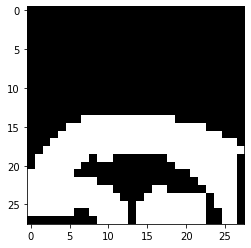

In [263]:
tdl = iter(train_datasetLoader)
tdl = next(tdl)
print(tdl[0].shape) # this is the shape of images along with the batch size (100,1,28,28)
print(tdl[1].shape) # this is the shape of labels along with the batch size (100,13)
print(tdl[0][0].shape) # this is the shape of images alone (1,28,28)
print(tdl[1][0].shape) # this is the shape of label alone
plt.imshow(tdl[0][9].reshape(28,28),cmap="gray") # this is a image
print(tdl[1][9]) # this is the corresponding label

In [296]:
config = [
     # input_channels:int,no.of filters:int,filter_size:int,stride:int,padding:int
     (1,16,3,1,0),
     # MP - max pooling:string,filter_size:int,stride:int,padding:int
     ("MP",2,2,0),
     (16,32,3,1,0),
     ("MP",2,2,0),
    #  (32,64,3,1,0),
    #  ("MP",2,2,0)
]

In [265]:
def conv_output_size(img_size,padding,filter_size,stride,n_filters):
   size_ = (int((img_size + (2 * padding) - filter_size) / stride)) + 1
   return size_,size_,n_filters

In [266]:
def dense_layer_size(configuration,img_size):

  _,output_channels = 0,0
  layer_count = 0

  for config in configuration:
    
    layer_count += 1

    if config[0] == "MP":
      img_size,_,output_channels = conv_output_size(img_size,config[3],config[1],config[2],output_channels)
      print("Max Pooling Layer {} output dims :: ".format(layer_count),img_size,_,output_channels)

    else: 
      img_size,_,output_channels = conv_output_size(img_size,config[4],config[2],config[3],config[1])
      print("Conv Layer {} output dims :: ".format(layer_count),img_size,_,output_channels)
  
  return img_size,_,output_channels

In [297]:
width,heigth,channels = dense_layer_size(config,28)

Conv Layer 1 output dims ::  26 26 16
Max Pooling Layer 2 output dims ::  13 13 16
Conv Layer 3 output dims ::  11 11 32
Max Pooling Layer 4 output dims ::  5 5 32
Conv Layer 5 output dims ::  3 3 64
Max Pooling Layer 6 output dims ::  1 1 64


In [298]:
width * heigth * channels

64

In [309]:
class NeuralNet(nn.Module):

  def __init__(self):
    super(NeuralNet,self).__init__()

    self.layer1 = nn.Sequential(
        nn.Conv2d(1,16,3,1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.layer2 = nn.Sequential(
        nn.Conv2d(16,32,3,1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.layer3 = nn.Sequential(
        nn.Conv2d(32,64,3,1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2,2)
    )

    self.FC = nn.Sequential(
        nn.Linear(64,13),
        # nn.Softmax(dim=1)
    )

  def forward(self,x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = torch.flatten(x, 1)
    x = self.FC(x)
    return x


In [310]:
model = NeuralNet()

In [311]:
model.train()
print(model)

NeuralNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FC): Sequential(
    (0): Linear(in_features=64, out_features=13, bias=True)
  )
)


In [312]:
lr = 0.001
loss_fn = nn.CrossEntropyLoss() # reffer this blog https://neptune.ai/blog/pytorch-loss-functions
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

In [313]:
epochs = 30

all_epochs_loss = []
all_epochs_acc = []

for epoch in range(epochs):

  epoch_loss = 0
  epoch_accuracy = 0

  for batch_id,(image,label) in enumerate(train_datasetLoader):
  
    prediction = model(image)
    loss = loss_fn(prediction,label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = (prediction.argmax(dim=1) == label).float().mean()
    epoch_loss += (loss.item() / len(train_datasetLoader)) * 100
    epoch_accuracy += (acc.item() / len(train_datasetLoader)) * 100
   
    all_epochs_loss.append(epoch_loss)  
    all_epochs_acc.append(epoch_accuracy) 
    

  print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))


Epoch : 1, train accuracy : 73.29833326737082, train loss : 62.84501824279632
Epoch : 2, train accuracy : 81.29499988754584, train loss : 41.18433406203986
Epoch : 3, train accuracy : 83.49999986092251, train loss : 35.81207474321127
Epoch : 4, train accuracy : 84.52333337068573, train loss : 32.75664272159335
Epoch : 5, train accuracy : 85.14499994118998, train loss : 30.63258712490398
Epoch : 6, train accuracy : 85.66333317756659, train loss : 29.372704448799286
Epoch : 7, train accuracy : 86.14499990145364, train loss : 28.096924471358456
Epoch : 8, train accuracy : 86.22833334406201, train loss : 27.264825721581772
Epoch : 9, train accuracy : 86.7449999054272, train loss : 26.40082899977763
Epoch : 10, train accuracy : 86.93666653831791, train loss : 25.720140049854937
Epoch : 11, train accuracy : 87.15666669607141, train loss : 25.338583568731963
Epoch : 12, train accuracy : 87.44000003735204, train loss : 24.615429001549877
Epoch : 13, train accuracy : 87.49166669448203, train lo

In [314]:
torch.save(model.state_dict(), "TLModel2_30_1.pt")

In [316]:
model.load_state_dict(torch.load("/content/TLModel2_30_1.pt"))

<All keys matched successfully>

In [317]:
model.train()
print(model)

NeuralNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FC): Sequential(
    (0): Linear(in_features=64, out_features=13, bias=True)
  )
)


In [327]:
epochs = 30

all_epochs_loss = []
all_epochs_acc = []

for epoch in range(epochs):

  epoch_loss = 0
  epoch_accuracy = 0

  for batch_id,(image,label) in enumerate(train_datasetLoader):
  
    prediction = model(image)
    loss = loss_fn(prediction,label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc = (prediction.argmax(dim=1) == label).float().mean()
    epoch_loss += (loss.item() / len(train_datasetLoader)) * 100
    epoch_accuracy += (acc.item() / len(train_datasetLoader)) * 100
   
    all_epochs_loss.append(epoch_loss)  
    all_epochs_acc.append(epoch_accuracy) 
    
  print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))


Epoch : 1, train accuracy : 89.20999996860799, train loss : 19.806536902983975
Epoch : 2, train accuracy : 89.32833350698131, train loss : 19.641842571397657
Epoch : 3, train accuracy : 89.42500012119592, train loss : 19.585368381192296
Epoch : 4, train accuracy : 89.2750000059602, train loss : 19.567583681394655
Epoch : 5, train accuracy : 89.58833337823526, train loss : 18.908963720003772
Epoch : 6, train accuracy : 89.57500003774942, train loss : 19.220687759419263
Epoch : 7, train accuracy : 89.58333349227877, train loss : 18.964271263529838
Epoch : 8, train accuracy : 89.92000008622784, train loss : 18.696300566196445
Epoch : 9, train accuracy : 89.46666680773082, train loss : 19.070846267044537
Epoch : 10, train accuracy : 89.84833361705115, train loss : 18.49704089884954
Epoch : 11, train accuracy : 89.72166675329197, train loss : 18.685351076225427
Epoch : 12, train accuracy : 89.86666687329596, train loss : 18.292319929848105
Epoch : 13, train accuracy : 89.93499998251582, tra

In [328]:
torch.save(model.state_dict(), "TLModel2_30_2.pt")

In [348]:
model.eval()

NeuralNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (FC): Sequential(
    (0): Linear(in_features=64, out_features=13, bias=True)
  )
)

ground truth ::  3
predicted ::  3


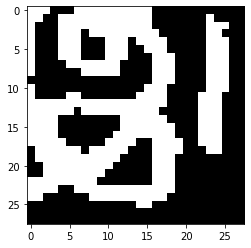

In [359]:
index = 59415

for_testing = train_transforms(train_X[index].reshape(28,28))
plt.imshow(for_testing.reshape(28,28),cmap="gray")
print("ground truth :: ",train_y[index].argmax() + 1)

predict = model(for_testing[None,...])
print("predicted :: ",predict.argmax(dim=1).item() + 1)